# Test a new strategies to bin the alignments

In [6]:
from glob import glob
from pathlib import Path
from scripts.get_features import BamWindows
from scripts.get_labels import read_knrgl, read_rmsk, label_windows
from collections import defaultdict
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

In [7]:
# read in the annotations
knrgl = read_knrgl(
    "/iblm/netapp/data4/mcuoco/sz_slavseq/resources/CommonBrain_insertions.bed"
)
rmsk = read_rmsk("/iblm/netapp/data4/mcuoco/sz_slavseq/resources/hs38d1.fa.out")

In [8]:
# set up various filters
read_filters = {
    "dup_unmapped": lambda r: not (r.is_duplicate or r.is_unmapped),
    "dup_unmapped_lowmapq": lambda r: not (
        r.is_duplicate or r.is_unmapped or r.mapping_quality < 10
    ),
    "dup_unmapped_unique": lambda r: not (
        r.is_duplicate or r.is_unmapped or r.mapping_quality < 60
    ),
    "dup_unmapped_lowmapq_sec_sup": lambda r: not (
        r.is_duplicate
        or r.is_unmapped
        or r.mapping_quality < 10
        or r.is_secondary
        or r.is_supplementary
    ),
    "dup_unmapped_lowmapq_sec_sup_highya": lambda r: (
        not (
            r.is_duplicate
            or r.is_unmapped
            or r.mapping_quality < 10
            or r.is_secondary
            or r.is_supplementary
        )
    )
    and (r.has_tag("YA") and r.get_tag("YA") > 20),
    "dup_unmapped_lowmapq_sec_sup_highya_lowyg": lambda r: (
        not (
            r.is_duplicate
            or r.is_unmapped
            or r.mapping_quality < 10
            or r.is_secondary
            or r.is_supplementary
        )
    )
    and (
        r.has_tag("YA")
        and r.get_tag("YA") > 20
        and r.has_tag("YG")
        and r.get_tag("YG") < 10
    ),
    "dup_unmapped_unique_sec_sup": lambda r: not (
        r.is_duplicate
        or r.is_unmapped
        or r.mapping_quality < 60
        or r.is_secondary
        or r.is_supplementary
    ),
    "dup_unmapped_unique_sec_sup_highya": lambda r: (
        not (
            r.is_duplicate
            or r.is_unmapped
            or r.mapping_quality < 60
            or r.is_secondary
            or r.is_supplementary
        )
    )
    and (r.has_tag("YA") and r.get_tag("YA") > 20),
    "dup_unmapped_unique_sec_sup_highya_lowyg": lambda r: (
        not (
            r.is_duplicate
            or r.is_unmapped
            or r.mapping_quality < 60
            or r.is_secondary
            or r.is_supplementary
        )
    )
    and (
        r.has_tag("YA")
        and r.get_tag("YA") > 20
        and r.has_tag("YG")
        and r.get_tag("YG") < 10
    ),
}

window_filters = {
    "1read": lambda w: w["total_reads"] >= 1,
    "3read": lambda w: w["total_reads"] >= 3,
    "3read_highya": lambda w: w["total_reads"] >= 3
    and w["YA_mean"] > 20
    and w["YG_mean"] < 10,
    "r1_3read": lambda w: w["r1_fwd"] >= 3 or w["r1_rev"] >= 3,
    "r1_3read_highya": lambda w: (w["r1_fwd"] >= 3 or w["r1_rev"] >= 3)
    and w["YA_mean"] > 20
    and w["YG_mean"] < 10,
}

In [9]:
f = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/results/align/CommonBrain/plate1_A4_S22.aln.tagged.sorted.bam"
res = {k: BamWindows(f, 750, 250, rf).bam_windows() for k, rf in read_filters.items()}

In [10]:
def covered(windows, annotation):

    windows = pr.PyRanges(windows)
    annotation = pr.PyRanges(annotation)

    return len(windows.overlap(annotation)), len(annotation.overlap(windows))

In [11]:
plot = defaultdict(list)
for rf_name, r in res.items():
    plot["rf"].append(rf_name)
    plot["total_windows"].append(len(r))
    knrgl_windows, knrgl_cov = covered(r, knrgl)
    rmsk_windows, rmsk_cov = covered(r, rmsk)
    plot["knrgl_windows"].append(knrgl_windows)
    plot["knrgl_cov"].append(knrgl_cov)
    plot["rmsk_windows"].append(rmsk_windows)
    plot["rmsk_cov"].append(rmsk_cov)

plot = pd.DataFrame(plot)
plot = pd.melt(plot, id_vars="rf")

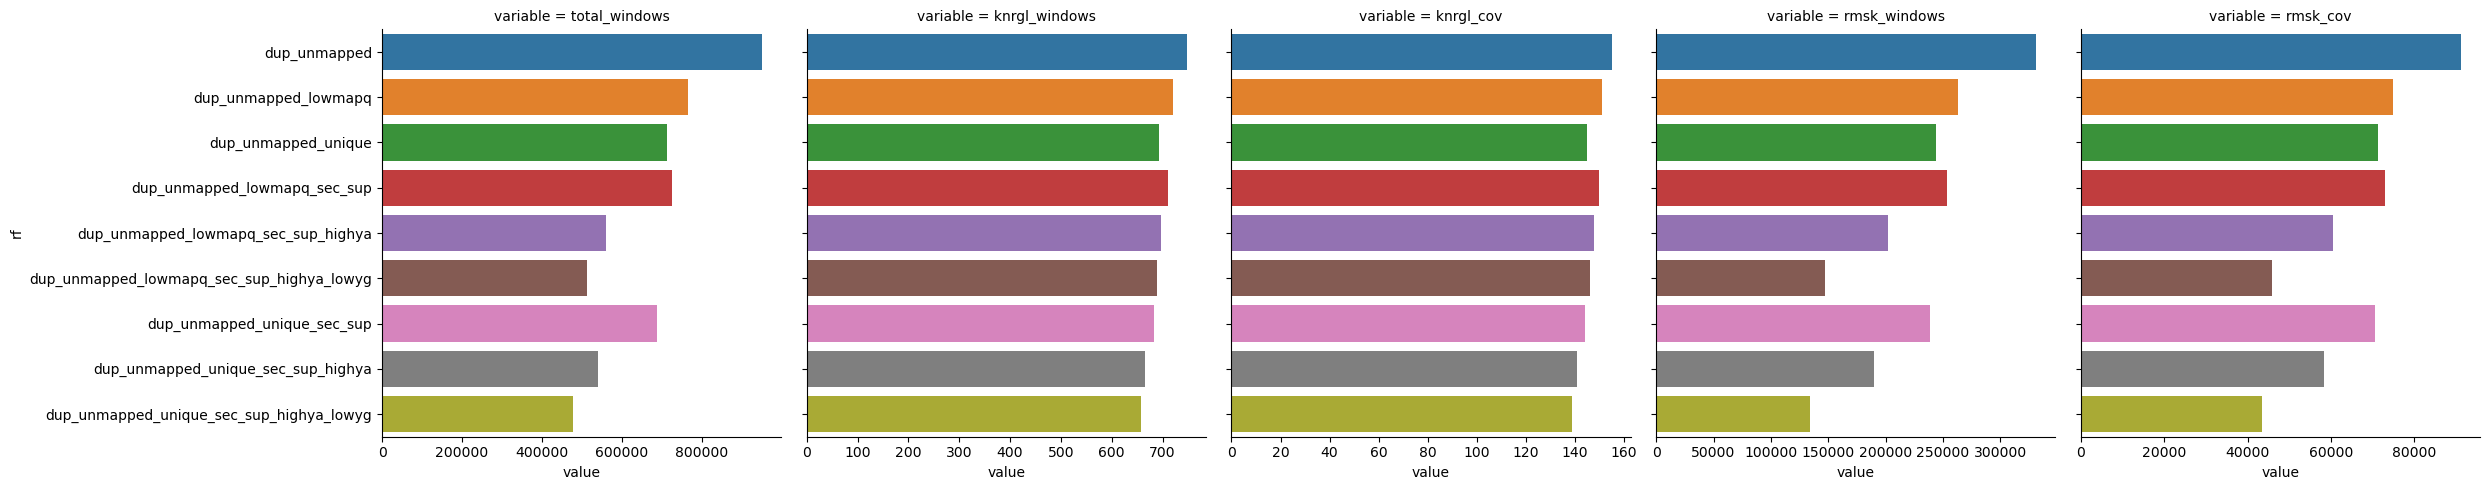

In [12]:
sns.catplot(
    data=plot,
    x="value",
    y="rf",
    col="variable",
    kind="bar",
    sharex=False,
)